## Import Libraries

In [60]:
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
from scipy import stats, integrate
import matplotlib.pyplot as plt
import sys,  datetime, os

## Load Data

In [61]:
X1 = pd.read_table('Output/L1000_signatures_2018_07.tsv')
X1.set_index(X1.columns[0], inplace = True)
X1 = X1.T
X1.head(1)

Sig,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,213721_at,...,204662_at,203047_at,203343_at,217995_at,218450_at,212536_at,218529_at,211071_s_at,203341_at,205379_at
6842999,0.006782,-0.030192,0.007706,-0.021802,-0.010061,-0.002261,-0.026392,0.02041,-0.035585,-0.00573,...,0.057445,0.043842,0.019188,0.046815,0.032323,0.008444,-0.042954,-0.040237,-0.005864,0.076068


In [62]:
X2 = pd.read_table('Output/Morg2f_BMatrix_map_2018_07.tsv')
X2[X2.columns[0]] = X2[X2.columns[0]].astype(str)
X2.set_index(X2.columns[0], inplace = True)
X2.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
10052040,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Get only drugs shared by the two dfs

In [26]:
shared_drugs = sorted(list(set(X1.index) & set(X2.index)))

In [27]:
X1 = X1.loc[shared_drugs]
X2 = X2.loc[shared_drugs]
print(X1.shape, X2.shape)

(4848, 978) (4848, 2048)


## Similarity Matrix then Eliminate Sparse Rows and Columns

In [143]:
sim_mat = 1-metrics.pairwise.pairwise_distances(X1.values.T, X2.values.T, metric='cosine')


In [144]:
x = []
for i in sim_mat:
    x.append(list(i).count(0))

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


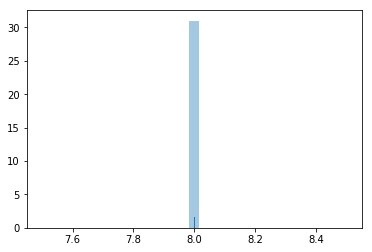

In [145]:
sns.distplot(x, rug = True)

In [158]:
count = 0
sim_mat_corrected = []
x1_columns = []

for i in range(len(sim_mat)):
    if list(sim_mat[i]).count(0) <= 9:
        sim_mat_corrected.append(sim_mat[i])
        count += 1
        x1_columns.append(X1.columns[i])
        sim_mat_array = np.asarray(sim_mat_corrected)
print(count)

978


In [147]:
df = pd.DataFrame(sim_mat_array, index=x1_columns, columns=X2.columns)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
200814_at,0.0,0.0,0.0,-0.011091,0.0,0.0,0.0,0.0,-0.013354,0.003417,...,0.014898,0.013694,0.006965,0.002732,0.013917,0.015375,0.008839,0.009303,0.005596,0.023282
222103_at,0.0,0.0,0.0,-0.003295,0.0,0.0,0.0,0.0,-0.011710,0.036258,...,0.011287,0.025431,0.011009,0.009389,0.024642,0.018820,0.022456,0.018695,0.020831,0.009094
201453_x_at,0.0,0.0,0.0,0.022351,0.0,0.0,0.0,0.0,0.014378,0.025409,...,0.010874,0.022882,0.017297,0.015961,0.021456,0.022237,0.028223,0.024601,0.022694,-0.002395
204131_s_at,0.0,0.0,0.0,0.009199,0.0,0.0,0.0,0.0,-0.010192,-0.013039,...,0.072440,0.045357,0.074399,0.081133,0.045345,0.039892,0.081275,0.071969,0.078742,0.038537
200059_s_at,0.0,0.0,0.0,0.024434,0.0,0.0,0.0,0.0,0.009719,0.013805,...,-0.018542,-0.013115,-0.013436,-0.017159,-0.011136,-0.013488,-0.007996,-0.010486,-0.009965,-0.013498


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


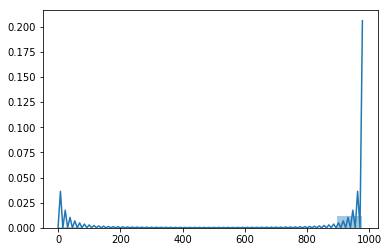

In [148]:
sns.distplot(list(df.astype(bool).sum(axis=0)))

In [149]:
col_drop = []
amt_nonzero = df.astype(bool).sum(axis=0)
for amt in amt_nonzero.iteritems():
    if amt[1] <100:
        col_drop.append(amt[0])

In [150]:
col_drop[:5]

['0', '1', '2', '4', '5']

In [151]:
df = df.drop(columns = col_drop)
df.head()

,3,8,9,10,11,13,14,15,16,17,...,157,158,159,160,161,162,163,164,165,166
200814_at,-0.011091,-0.013354,0.003417,0.012982,-0.012527,0.014326,0.013443,0.006925,-0.009253,-0.040703,...,0.014898,0.013694,0.006965,0.002732,0.013917,0.015375,0.008839,0.009303,0.005596,0.023282
222103_at,-0.003295,-0.011710,0.036258,-0.028671,-0.019479,0.006791,-0.002465,0.005560,0.015561,0.011671,...,0.011287,0.025431,0.011009,0.009389,0.024642,0.018820,0.022456,0.018695,0.020831,0.009094
201453_x_at,0.022351,0.014378,0.025409,-0.029914,0.018798,-0.014696,-0.003362,0.020814,0.027980,-0.011520,...,0.010874,0.022882,0.017297,0.015961,0.021456,0.022237,0.028223,0.024601,0.022694,-0.002395
204131_s_at,0.009199,-0.010192,-0.013039,-0.016740,-0.007696,0.013206,0.016130,-0.003153,-0.016337,0.009852,...,0.072440,0.045357,0.074399,0.081133,0.045345,0.039892,0.081275,0.071969,0.078742,0.038537
200059_s_at,0.024434,0.009719,0.013805,-0.001409,0.020113,-0.001165,0.020846,0.009307,-0.003389,-0.013907,...,-0.018542,-0.013115,-0.013436,-0.017159,-0.011136,-0.013488,-0.007996,-0.010486,-0.009965,-0.013498


In [152]:
df.shape

(978, 159)

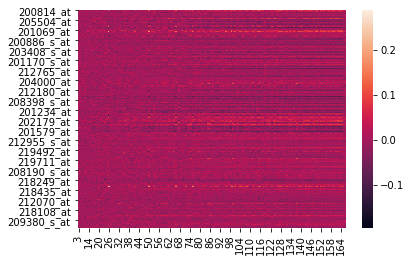

In [153]:
sns.heatmap(df)

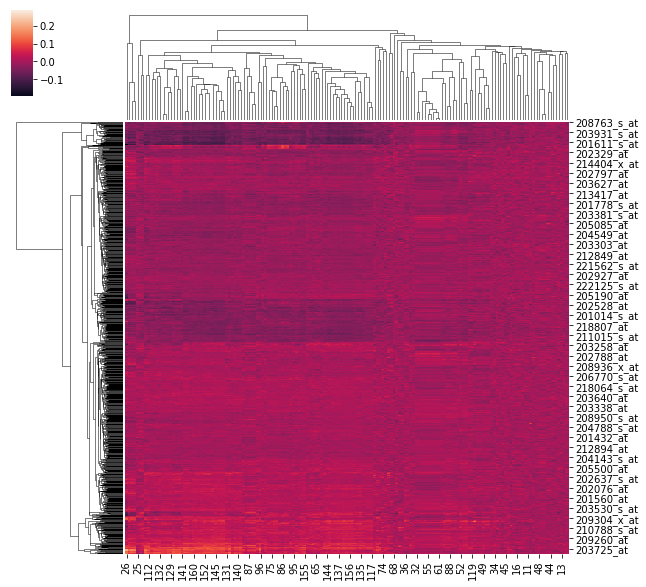

In [154]:
clustermap = sns.clustermap(pd.DataFrame(df))

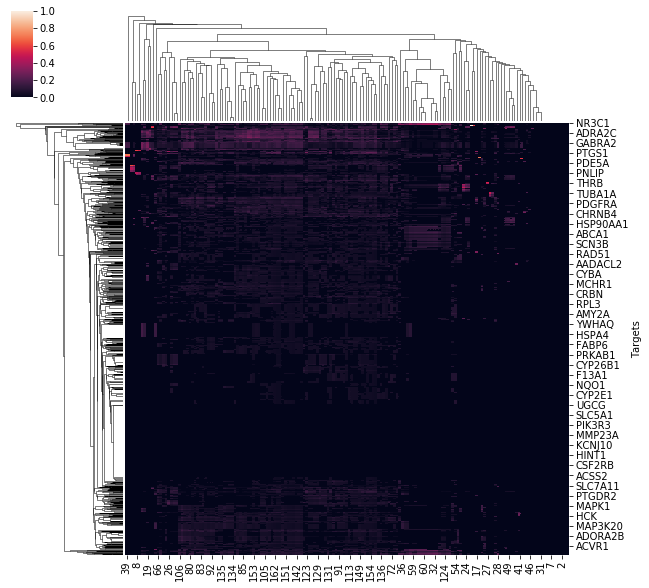

In [50]:
#compare to clustermap that didn't eliminate sparse rows and columns
clustermap = sns.clustermap(pd.DataFrame(sim_mat, index=X1.columns, columns=X2.columns))

## Eliminate Sparse Rows and Columns  then create Similarity Matrix

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


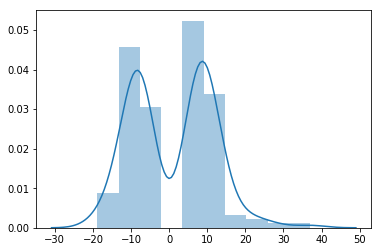

In [50]:
sns.distplot(list(X1.sum(axis=0)))

In [51]:
x1_col_drop = []
x1_amt_nonzero = X1.sum(axis=0)
for amt in x1_amt_nonzero.iteritems():
    if abs(amt[1]) < 10:
        x1_col_drop.append(amt[0])
        
X1 = X1.drop(columns = x1_col_drop)
X1.head()

Sig,204131_s_at,201471_s_at,204695_at,203665_at,201502_s_at,212143_s_at,208687_x_at,202240_at,218245_at,201555_at,...,217168_s_at,221531_at,218679_s_at,203973_s_at,209304_x_at,205088_at,204489_s_at,204826_at,205909_at,209260_at
10000456,-0.009158,0.000062,-0.042393,-0.026619,0.017480,-0.006445,0.015363,0.004811,0.001908,-0.007478,...,0.053494,0.028163,0.063155,0.027536,0.006675,0.028045,0.036596,0.038245,0.012695,-0.014548
100018,-0.002719,-0.012214,-0.013371,-0.076161,0.019521,0.005802,-0.021528,-0.011691,0.013236,-0.004414,...,0.036478,0.034159,0.060041,-0.049771,-0.071728,-0.006934,0.037844,-0.005737,-0.004063,0.020973
10008573,-0.007252,-0.003264,-0.019180,-0.006205,0.007659,-0.028196,0.025231,0.029273,-0.018479,0.005308,...,-0.021761,0.025413,-0.021918,0.006390,0.003754,-0.015731,0.027355,-0.010611,-0.014431,0.015462
10022508,-0.031028,0.012703,0.034373,0.431023,-0.088464,-0.016732,0.058939,-0.037692,-0.016298,-0.026397,...,-0.048621,-0.000361,-0.011948,0.014212,0.016070,0.013617,-0.000741,0.005845,0.003675,0.048273
10040286,0.014321,0.011023,-0.000231,-0.004878,0.008103,-0.007608,0.017297,0.005437,0.039642,-0.002348,...,-0.051611,0.012239,0.003943,-0.027971,-0.006325,0.208341,0.014542,0.038571,0.010010,0.048378


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


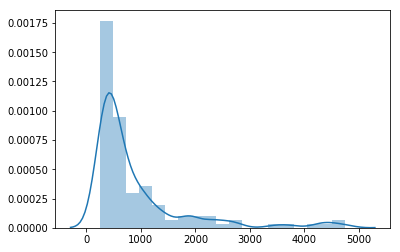

In [55]:
sns.distplot(list(X2.sum(axis=0)))

In [56]:
x2_col_drop = []
x2_amt_nonzero = X2.sum(axis=0)
for amt in x2_amt_nonzero.iteritems():
    if amt[1] <250:
        x2_col_drop.append(amt[0])
        
X2 = X2.drop(columns = x2_col_drop)
X2.head()

,0,1,2,3,4,5,6,8,11,16,...,1932,1950,1990,2008,2017,2034,2039,2040,2041,2044
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
10000456,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
100018,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10008573,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
10022508,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
10040286,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [57]:
shared_drugs = sorted(list(set(X1.index) & set(X2.index)))
X1 = X1.loc[shared_drugs]
X2 = X2.loc[shared_drugs]
print(X1.shape, X2.shape)

(4848, 51) (4848, 129)


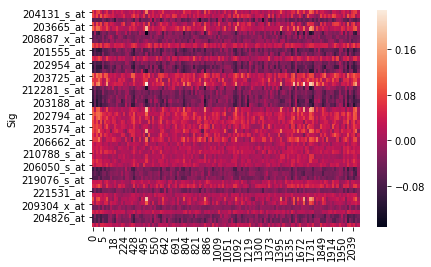

In [58]:
sim_mat = 1- metrics.pairwise.pairwise_distances(X1.values.T, X2.values.T, metric='cosine')
sns.heatmap(pd.DataFrame(sim_mat, index=X1.columns, columns=X2.columns))

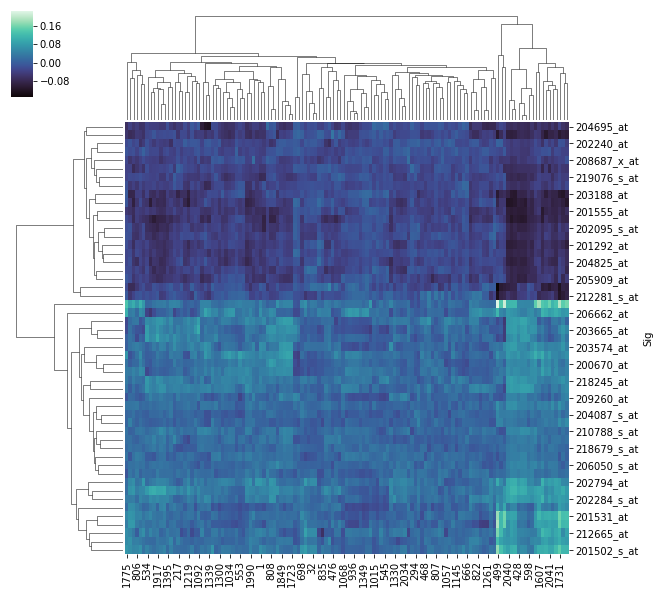

In [59]:
sns.clustermap(pd.DataFrame(sim_mat, index=X1.columns, columns=X2.columns), cmap="mako")

In [250]:
filename = 'l100_top.tsv.zip'### % str(datetime.date.today())[0:7].replace('-', '_')
sim_df = pd.DataFrame(sim_mat, index=X1.columns, columns=X2.columns)
sim_df.to_csv(filename, sep='\t', compression='gzip')